# Vary Much Optimal

This document was inspired by [this blogpost](http://www.inference.vc/evolution-strategies-variational-optimisation-and-natural-es-2/) by Ferenc Huszár which was in turn inspired by [this paper](http://www.jmlr.org/papers/volume15/wierstra14a/wierstra14a.pdf) by Wiersta et al and [this paper](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-65.pdf) by Barber et al. I was a fascinated by all of this and I just had to reproduce it myself. I'm sharing some personal findings based on that work here but any proper attribution should also link to the previously mentioned documents as I am largely just repeating their work.

Let's demonstrate the maths behind the idea. 

$$
\begin{split}
\frac{d}{d\theta} \mathbb{E}_{x \sim p(x|\theta)} f(x) &= \frac{d}{d\theta}\int p(x|\theta)f(x)dx \\
 &= \int \frac{d}{d\theta} p(x|\theta)f(x)dx
\end{split}
$$

So far so good. Let's now apply a trick. We will rewrite the contents of the last integral in a bit. To understand why we are able to do that, please remember the chain rule of derivatives;

$$
\frac{d}{dx} f(g(x)) = g'(x) f'(g(x))
$$

We will now apply the chain rule on the following statement. 

$$ 
\frac{d}{d\theta} \log p(x|\theta) = \frac{\frac{d}{d\theta}p(x|\theta)}{p(x|\theta)}
$$ 

You may begin to wonder why this is such a useful step. Hopefully it comes clear when we multiply both sides by $p(x|\theta)$. 

$$
\begin{split}
\frac{d}{d\theta} \log p(x|\theta) & = \frac{\frac{d}{d\theta}p(x|\theta)}{p(x|\theta)} \\
p(x|\theta) \frac{d}{d\theta} \log p(x|\theta) & = p(x|\theta) \frac{\frac{d}{d\theta}p(x|\theta)}{p(x|\theta)} \\
p(x|\theta) \frac{d}{d\theta} \log p(x|\theta) & = \frac{d}{d\theta} p(x|\theta)
\end{split}
$$

Let us now use this to continue our train of thought. 

$$
\begin{split}
\frac{d}{d\theta} \mathbb{E}_{x \sim p(x|\theta)} f(x) &= \frac{d}{d\theta}\int p(x|\theta)f(x)dx \\
 &= \int \frac{d}{d\theta} p(x|\theta)f(x)dx \\ 
 &= \int p(x|\theta)\frac{d}{d\theta} \log p(x|\theta)f(x)dx
\end{split}
$$

That seems useful, let's rearrange and conclude! 

$$
\begin{split}
\frac{d}{d\theta} \mathbb{E}_{x \sim p(x|\theta)} f(x) &= \frac{d}{d\theta}\int p(x|\theta)f(x)dx \\
 &= \int \frac{d}{d\theta} p(x|\theta)f(x)dx \\ 
 &= \int p(x|\theta)\frac{d}{d\theta} \log p(x|\theta)f(x)dx \\ 
 &= \int p(x|\theta) f(x) \frac{d}{d\theta} \log p(x|\theta)dx \\
 &= \mathbb{E}_{x \sim p(x|\theta)} \left< f(x) \frac{d}{d\theta} \log p(x|\theta) \right>
\end{split}
$$

The implications of this are pretty interesting. Suppose we have a naughty $f(x)$ that is hard to optimise then we may look for a variational distribution $p(x|\theta)$ and perform a gradient search on that instead. The above formula shows that we'll always be able to derive a gradient (even in cases where $f(x)$ is not continous).

The easiest variational function to work with should be the gaussian. 

...

In [15]:
import numpy as np
import matplotlib.pylab as plt
import numba as nb

from matplotlib.patches import Ellipse
%matplotlib inline

In [126]:
def integrate(f, minval, maxval, granualarity=100):
    x = np.linspace(minval, maxval, granualarity)
    return np.sum(f(x)) * (maxval - minval) / granualarity

def variationalizer(f, mu, sigma, minval=-4, maxval=4):
    const = 1/np.sqrt(2*np.pi*sigma**2)
    to_opt = lambda x: f(x)*np.exp(-(x-mu)**2/(2.*sigma**2))
    return const * integrate(to_opt, -6, 6, 1000)

@nb.jit
def make_variational(f_orig, f_variational, 
                     extend_mu = [-2, 10], 
                     extend_sigma = [0.1, 2], 
                     grid_param = 40):
    res = []
    for s in reversed(np.linspace(extend_sigma[0], extend_sigma[1], grid_param)):
        row = []
        for m in np.linspace(extend_mu[0], extend_mu[1], grid_param):
            if(s == 0.0):
                row.append(f_orig(m))
            else:
                if f_variational(f_orig, m, s) > 10:
                    print(m, s, f_variational(f_orig, m, s))
                row.append(f_variational(f_orig, m, s))
        res.append(row)
    return res

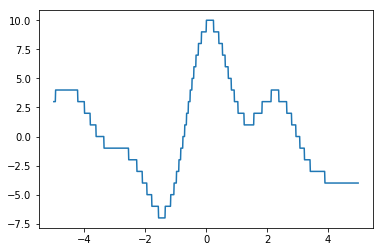

In [334]:
# f = lambda x: np.sinc(x)
f = lambda x: np.floor(np.sinc(x) * 10 + 4*np.sin(x))
xs = np.arange(-5, 5, 0.01)

plt.plot(xs, f(xs))

$$ \mathbb{E}[f(x)] = \int f(x) p(x) dx = \int f(x) p(x|\mu, \sigma) dx$$ 

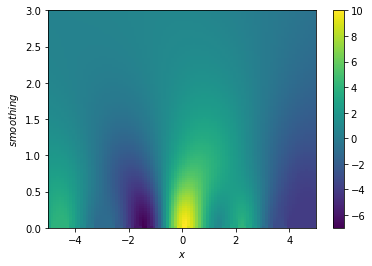

In [335]:
min_mu, max_mu, min_sigma, max_sigma, grid_param = -5, 5, 0, 3, 100
mat_v = make_variational(f, variationalizer, 
                         extend_mu=[min_mu, max_mu], 
                         extend_sigma=[min_sigma, max_sigma],
                         grid_param=grid_param)
plt.imshow(mat_v, aspect='auto', extent=[min_mu, max_mu, min_sigma, max_sigma], interpolation='none')
# plt.title("region to optimise variationally")
plt.xlabel("$x$")
plt.ylabel("$smoothing$")
_ = plt.colorbar();

# Contour Plot

In [336]:
y_v = np.linspace(max_sigma, min_sigma, grid_param)
x_v = np.linspace(min_mu, max_mu, grid_param)
z_v = mat_v

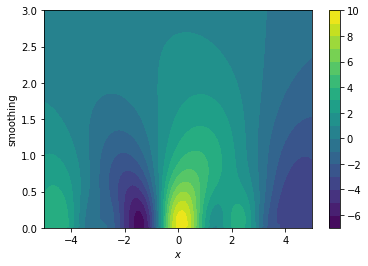

In [337]:
contour = plt.contourf(x_v,y_v,z_v, 20)
_ = plt.colorbar();
plt.xlabel("$x$")
plt.ylabel("smoothing")

What is happening internally? 

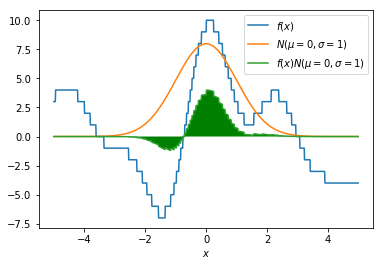

In [415]:
sigma = 1
mu = 0
xs = np.arange(-5, 5, 0.01)

n = lambda xs: 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(xs-mu)**2/(2.*sigma**2))

fx, = plt.plot(xs, f(xs), label="$f(x)$")
gx, = plt.plot(xs, n(xs)*20, label="$N(\mu={}, \sigma={})$".format(mu, sigma))
hx, = plt.plot(xs, f(xs)*n(xs), label="$f(x) N(\mu={}, \sigma={})$".format(mu, sigma))
plt.fill_between(xs, f(xs)*n(xs), facecolor='green')
plt.legend(handles=[fx, gx, hx])
plt.xlabel("$x$")

In [409]:
np.sum(f(xs)*n(xs)*0.01)

3.4891078209656023

0 [8.6285780231890907]


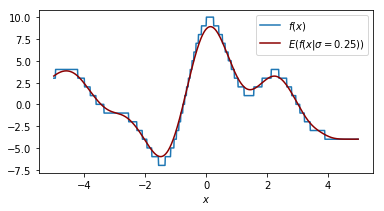

In [436]:
sigma = 0.25
xs = np.arange(-5, 5, 0.01)

g = lambda xs: [variationalizer(f, x, sigma) for x in xs]

plt.figure(figsize=(6, 3))
fx, = plt.plot(xs, f(xs), label="$f(x)$")
gx, = plt.plot(xs, g(xs), label="$E(f(x|\sigma={}))$".format(sigma), c="darkred")
# plt.scatter([mu], g([mu]), c="green")
print(mu, g([mu]))
plt.legend(handles=[fx, gx])
plt.xlabel("$x$")

Another way to look at it is to see how $E_{p(x|\mu, \sigma)}[f(x)]$ behaves as we increase the variance. 

Remember that; 

$$ E[f(x)] = \int p(x) f(x) dx $$ 

So for us; 

$$
\begin{split}
E_{p(x|\mu, \sigma)}[f(x)] = & \int p(x|\mu, \sigma) f(x) dx\\
& \int \frac{1}{\sqrt{2\pi\sigma^2}} \exp{-\frac{(x-\mu)^2}{2\sigma^2}} f(x) dx \\
& \frac{1}{\sqrt{2\pi\sigma^2}} \int \exp{-\frac{(x-\mu)^2}{2\sigma^2}} f(x) dx
\end{split}
$$

The larger $\sigma$ is, the less peaky $E_{p(x|\mu, \sigma)}[f(x)]$ will be, effectively any spot where the search space has a large value for $sigma$ is a region where we describe to be uncertain of being near an optimum. 

You may be able to imagine that searching the $\mu, \sigma$-space is actually rather pleasant because;

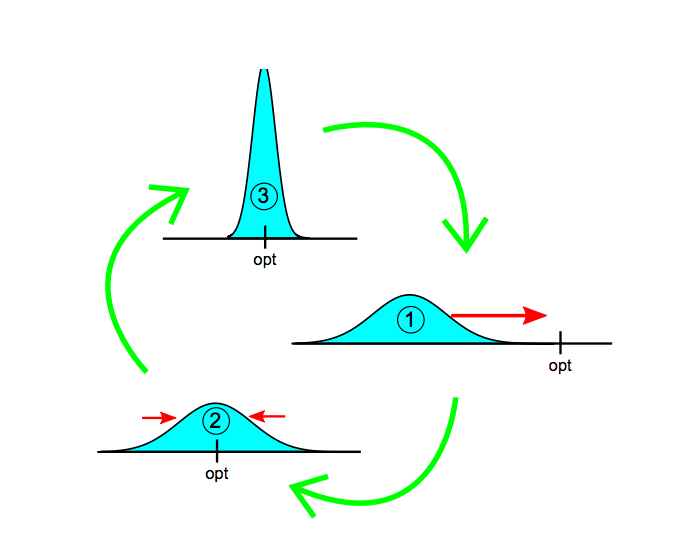

## Gradients!

Let's try to code this up with numpy.

[ 0.97837521  0.96007795]


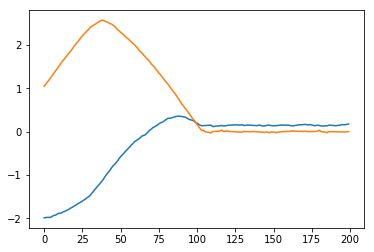

In [348]:
mus, sigmas = [], []
mu, sigma = -2, 1

def mcmc_gradient_step(f, mu, sigma, n=50): 
    theta = np.array([mu, sigma])
    noise = theta + np.random.normal(0, scale=0.01, size=(n,2))
    reward = [variationalizer(f, m, s) for m,s in noise]
    direction = (np.array(reward) - np.mean(reward))/np.std(reward)
    return theta + 0.1*np.dot(noise.T, direction)

print(mcmc_gradient_step(f, mu=1, sigma=1))


for _ in range(200):
    mu, sigma = mcmc_gradient_step(f, mu, sigma)
    mus.append(mu)
    sigmas.append(sigma)

plt.plot(mus)
plt.plot(sigmas);

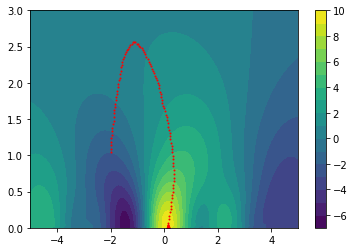

In [349]:
contour = plt.contourf(x_v,y_v,z_v, 20)
_ = plt.colorbar()
plt.ylim(0, 3)
plt.scatter(mus, sigmas, c='red', s=1);

# Higher Dimensions 

This trick looks nice for 1 dimensional problems. But what about the higher dimensions?

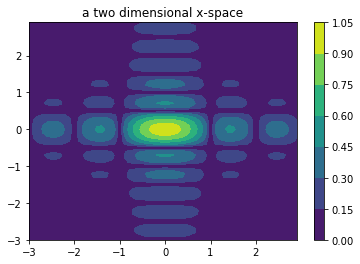

In [28]:
# h stands for hard-function
def hard_func(args):
    x, y = args
    return np.sqrt(np.abs(np.sinc(2*x))) * np.sqrt(np.abs(np.sinc(y)))

xs = np.arange(-3, 3, 0.1)
ys = np.arange(-3, 3, 0.1)
zs = [] 

for i in xs:
    row = []
    for j in ys: 
        row.append(hard_func([i,j]))
    zs.append(row)

contour = plt.contourf(xs,ys,np.array(zs), 6)
plt.title("a two dimensional x-space")
_ = plt.colorbar();

To make a general solution for this, let us first consider that we can also use sampling for our integration technique.


$$
\begin{split}
\frac{d}{d\theta} \mathbb{E}_{x \sim p(x|\theta)} f(x) = \mathbb{E}_{x \sim p(x|\theta)} f(x) \frac{d}{d\theta} \log p(x|\theta)
\end{split}
$$

For a [gaussian](http://www.notenoughthoughts.net/posts/normal-log-likelihood-gradient.html)

$$
\frac{d}{d\theta} \log p(x|\theta) \to \\\\
\frac{dp(x|\theta)}{d\mu} = \frac{1}{\sigma}(x-\mu) \\\\
\frac{dp(x|\theta)}{d\sigma^2} = -\frac{1}{2\sigma^2}\left(1-\frac{1}{\sigma^2}(x-\mu)^2 \right)
$$

Moar maths! Thanks to the matrix cookbook!

$$ 
\begin{split}
\theta^{\text{new}} & = \theta - \frac{\alpha}{S} \sum_S f(x^s) \frac{d}{d\theta} \log p(x^s|\theta)\\
\begin{bmatrix} \mu \\ \Sigma \\\end{bmatrix}^{\text{new}}
  & = \begin{bmatrix} \mu \\ \Sigma \\\end{bmatrix} 
    - \frac{\alpha}{S} \sum_S f(x^s) 
     \begin{bmatrix} 
        \Sigma^{-1}(x^s-\mu) \\ 
        -\frac{1}{2}(\Sigma^{-1} - \Sigma^{-1}(x^s-\mu)(x^s-\mu)^T\Sigma^{-1}) \\
     \end{bmatrix}
\end{split}
$$

In [469]:
def formula_update_orig(f, mu, sigma, alpha=0.05, n=50, max_sigma=10):
    mu_arr = np.array(mu).reshape(2)
    dmu, dsigma = np.zeros(shape=mu.shape).T, np.zeros(shape=sigma.shape)
    for i in range(n):
        xs = np.random.multivariate_normal(mu_arr, sigma)
        inv_sigma = np.linalg.inv(sigma)
        dmu += np.matrix(alpha/n * f(xs) * inv_sigma * (xs-mu).T)
        sigma_part = -alpha/n * f(xs)*(inv_sigma - inv_sigma*(xs-mu).T*(xs-mu)*inv_sigma)/2 
        dsigma += sigma_part
    new_mu = (mu.T + dmu).reshape((1,2))
    new_sigma = sigma + dsigma
    # now comes the dirty numerics 
    new_sigma[new_sigma > max_sigma] = max_sigma
    new_sigma[new_sigma > sigma*2] = 0.1
    # TODO! new_sigma[new_sigma > sigma*2] = sigma[new_sigma > sigma*2]
    new_sigma[new_sigma < 0.05] = 0.05
    return new_mu, new_sigma

def hard_func(args):
    x, y = args
    return np.sqrt(np.abs(np.sinc(2*x))) * np.sqrt(np.abs(np.sinc(y)))

In [475]:
def apply_algorithm(func, start_mu, start_sigma, formula_update, iterations=2000, stop_early=False, **kwargs):
    mus = [start_mu] 
    sigmas = [start_sigma] 
    alpha = kwargs.get("alpha") if kwargs.get("alpha") else 0.1
    n_sim = kwargs.get("n_sim") if kwargs.get("n_sim") else 25
    for _ in range(iterations):
        mu, sigma = formula_update_orig(func, mus[-1], sigmas[-1], alpha=alpha, n=n_sim)
        if stop_early: 
            if np.max(sigma) < stop_early:
                print("stopping early after {} iterations".format(len(mus)))
                break
        mus.append(mu)
        sigmas.append(sigma)
    return mus, sigmas

def plot_func_space(func, axis_range=[-5, 5], axis_resolution=0.1, n_countour=10):
    ticks = np.arange(axis_range[0], axis_range[1], step=axis_resolution)
    zs = [] 

    for i in ticks:
        row = []
        for j in ticks: 
            row.append(func([i,j]))
        zs.append(row)

    contour = plt.contourf(ticks, ticks, np.array(zs), n_countour)
    _ = plt.colorbar();
    return contour

def plot_mu_space(mus, alpha=0.1, plot_every=1):
    to_plot = mus[::plot_every]
    sigmas = [[1] for _ in mus]
    plt.scatter(x=[_[:,0] for _ in to_plot], 
                y=[_[:,1] for _ in to_plot], s=sigmas, c="r", alpha=alpha)

mu = np.matrix([-3,2])
sigma = np.matrix([[4,0], [0,4]])
mus, sigmas = apply_algorithm(hard_func, mu, sigma, formula_update_orig, 
                              alpha=0.05, n_sim=100, iterations=5000, stop_early=0.1)
len(mus)

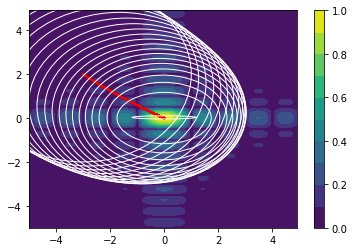

In [483]:
plot_func_space(hard_func)
ax = plt.subplot(111)
for i in range(len(mus))[::250]:
    ax.add_artist(Ellipse(xy=[float(mus[i][:,0]), float(mus[i][:,1])], 
                          width=sigmas[i][0,0]*2, 
                          height=sigmas[i][1,1]*2, 
                          edgecolor="white", fill=False))
plot_mu_space(mus, alpha=0.2)

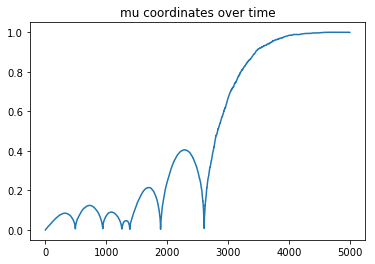

In [472]:
plt.plot([hard_func(np.array(m).reshape(2)) for m in mus])
plt.title("mu coordinates over time")

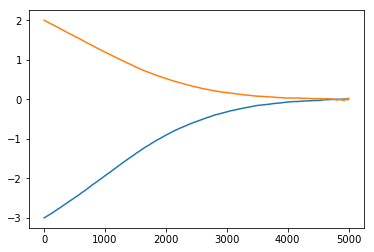

In [473]:
plt.plot([float(s[:,0]) for s in mus])
plt.plot([float(s[:,1]) for s in mus])

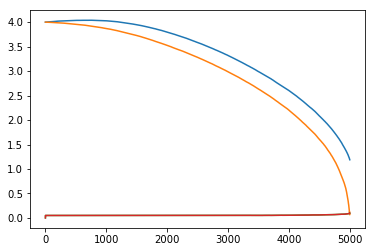

In [474]:
plt.plot([s[0,0] for s in sigmas])
plt.plot([s[1,1] for s in sigmas])
plt.plot([s[0,1] for s in sigmas])
plt.plot([s[1,0] for s in sigmas])

# Naughty Functions

Let's demonstrate that this also works on discrete functions.

In [521]:
import numpy as np

def rastrigin(x, y, a=10):
    """
    As defined on https://en.wikipedia.org/wiki/Rastrigin_function. 
    :param x: Input x
    :param x: Input y
    :param a: Hyperparameter: the spikey-ness of the landscape. 
    :return: 
    """
    return a - sum([(x**2 - a * np.cos(2 * np.pi * x)) for x in [x,y]])


def rosenbrock(x, y, a=1, b=100):
    """
    As defined on https://en.wikipedia.org/wiki/Rosenbrock_function.
    The optimal value can be found at x=a, y=a*a.
    :param x: Input 
    :param y: Input 
    :param a: Hyperparameter
    :param b: Hyperparameter
    :return: 
    """
    return (a - x)**2 + b*(y - x**2)**2


def sphere(x, y):
    """
    As defined on https://en.wikipedia.org/wiki/Rosenbrock_function.
    The optimal value can be found at x=0, y=0.
    :param x: Input 
    :param y: Input 
    :return: 
    """
    return x**2 + y**2


def ackley(x, y):
    """
    As defined on https://en.wikipedia.org/wiki/Test_functions_for_optimization
    The optimal value can be found at x=0, y=0.
    :param x: Input 
    :param y: Input 
    :return: 
    """
    part1 = -20*np.exp(-0.2*np.sqrt(0.5*(x**2 + y**2)))
    part2 = np.exp(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))) + np.exp(1) + 20
    return part1 + part2


def beale(x, y):
    """
    As defined on https://en.wikipedia.org/wiki/Test_functions_for_optimization
    The optimal value can be found at x=3, y=0.5
    :param x: Input
    :param y: Input
    :return: 
    """
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2


def booth(x, y):
    """
    As defined on https://en.wikipedia.org/wiki/Test_functions_for_optimization
    The optimal value can be found at x=1, y=3
    :param x: 
    :param y: 
    :return: 
    """
    return (x + 2*y - 7)**2 + (2*x + y - 5)**2

# `ackley` 

In [510]:
hard_func = lambda a: -ackley(a[0], a[1])
mu = np.matrix([4.5, 4.5])
sigma = np.matrix([[3,0], [0,3]])
mus, sigmas = apply_algorithm(hard_func, mu, sigma, formula_update_orig, 
                              alpha=0.05, n_sim=150, iterations=300, stop_early=0.11)

stopping early after 149 iterations


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


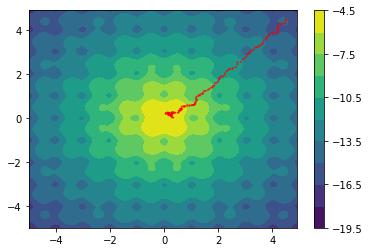

In [511]:
plot_func_space(hard_func)
# ax = plt.subplot(111)
# for i in range(len(mus))[::10]:
#     ax.add_artist(Ellipse(xy=[float(mus[i][:,0]), float(mus[i][:,1])], 
#                           width=sigmas[i][0,0]*2, 
#                           height=sigmas[i][1,1]*2, edgecolor="white", fill=False))
plot_mu_space(mus, alpha=0.7)

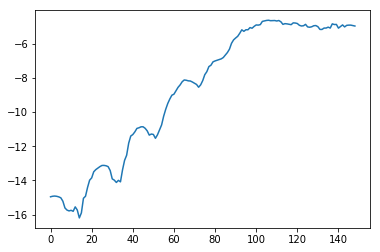

In [512]:
plt.plot([hard_func(np.array(m).reshape(2)) for m in mus])

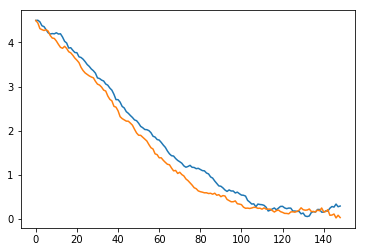

In [513]:
plt.plot([float(s[:,0]) for s in mus])
plt.plot([float(s[:,1]) for s in mus])

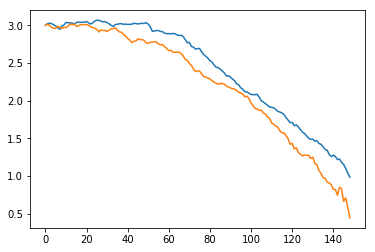

In [514]:
plt.plot([s[0,0] for s in sigmas])
plt.plot([s[1,1] for s in sigmas])

# `rastrigin` 

In [519]:
hard_func = lambda a: rastrigin(a[0], a[1])
mu = np.matrix([3.5, -4.5])
sigma = np.matrix([[3,0], [0,3]])
mus, sigmas = apply_algorithm(hard_func, mu, sigma, formula_update_orig, 
                              alpha=0.05, n_sim=150, iterations=300, stop_early=0.11)

stopping early after 59 iterations


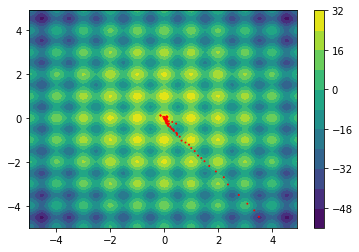

In [520]:
plot_func_space(hard_func)
# ax = plt.subplot(111)
# for i in range(len(mus))[::2]:
#     ax.add_artist(Ellipse(xy=[float(mus[i][:,0]), float(mus[i][:,1])], 
#                           width=sigmas[i][0,0]*2, height=sigmas[i][1,1]*2, 
#                           edgecolor="white", fill=False))
plot_mu_space(mus, alpha=0.9)

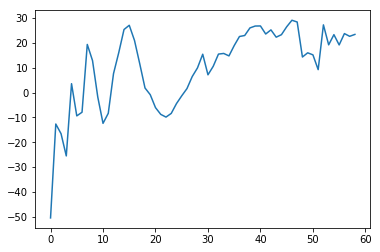

In [451]:
plt.plot([hard_func(np.array(m).reshape(2)) for m in mus])

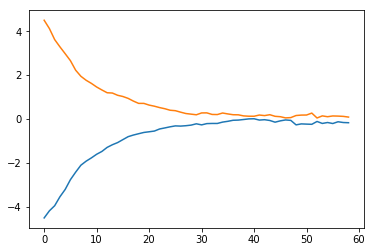

In [452]:
plt.plot([float(s[:,0]) for s in mus])
plt.plot([float(s[:,1]) for s in mus])

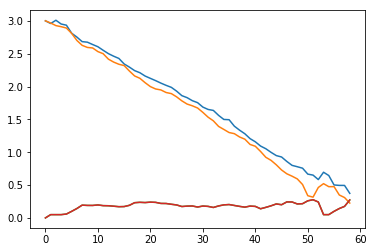

In [453]:
plt.plot([s[0,0] for s in sigmas])
plt.plot([s[1,1] for s in sigmas])
plt.plot([s[0,1] for s in sigmas])
plt.plot([s[0,1] for s in sigmas])

# never perfect

An example of when it works and fails. 

In [454]:
def hard_func(arr):
    x, y = arr
    bonus = 0
    if x**2 + y**2 > 5:
        if x**2 + y**2 < 6:
            bonus += 1.5
    if x**2 + y**2 < 0.01:
        if x**2 + y**2 < 6:
            bonus = 1.5
    return np.exp(-(x * y)**2) + bonus
mu = np.matrix([-4.5, 4.5])
sigma = np.matrix([[3,0], [0,3]])

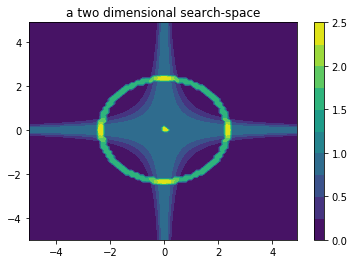

In [455]:
plot_func_space(hard_func)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


stopping early after 1421 iterations


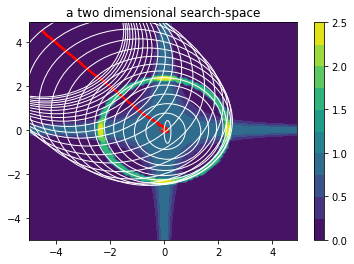

In [456]:
mus, sigmas = apply_algorithm(hard_func, mu, sigma, formula_update_orig, 
                              alpha=0.1, n_sim=100, iterations=2500, stop_early=0.11)
plot_func_space(hard_func)
ax = plt.subplot(111)
for i in range(len(mus))[::50]:
    ax.add_artist(Ellipse(xy=[float(mus[i][:,0]), float(mus[i][:,1])], 
                          width=sigmas[i][0,0]*2, 
                          height=sigmas[i][1,1]*2, 
                          edgecolor="white", fill=False))
plot_mu_space(mus, alpha=0.7)

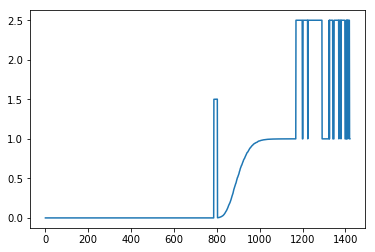

In [457]:
plt.plot([hard_func(np.array(m).reshape(2)) for m in mus])

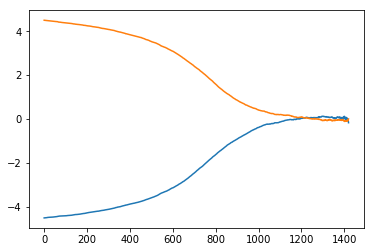

In [458]:
plt.plot([float(s[:,0]) for s in mus])
plt.plot([float(s[:,1]) for s in mus])

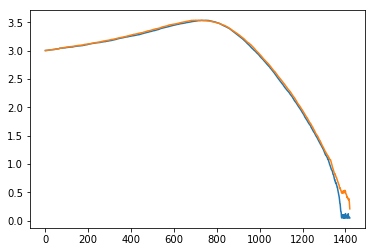

In [459]:
plt.plot([s[0,0] for s in sigmas])
plt.plot([s[1,1] for s in sigmas])

An example of when it doesn't.

In [460]:
def hard_func(arr):
    x, y = arr
    bonus = 0
    if x**2 + y**2 > 5:
        if x**2 + y**2 < 6:
            bonus += 1.5
    if x**2 + y**2 > 6 :
        if x**2 + y**2 < 10:
            bonus -= -2
    if (x-4)**2 + (y-4)**2 < 0.001:
            bonus += 5.5
    return np.exp(-(x * y)**2) + bonus

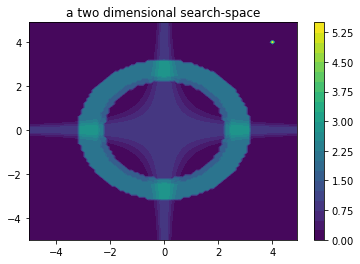

In [461]:
plot_func_space(hard_func, n_countour=22)

In [462]:
mu = np.matrix([-3, 3])
sigma = np.matrix([[5,0], [0,5]])

mus, sigmas = apply_algorithm(hard_func, mu, sigma, formula_update_orig, 
                              alpha=0.1, n_sim=100, iterations=2000, stop_early=0.11)

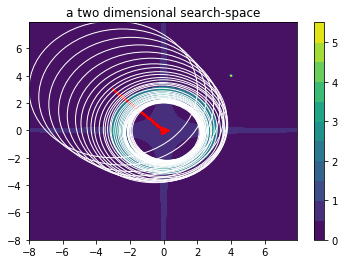

In [463]:
plot_func_space(hard_func, axis_range=[-8,8])
ax = plt.subplot(111)
for i in range(len(mus))[::50]:
    ax.add_artist(Ellipse(xy=[float(mus[i][:,0]), float(mus[i][:,1])], 
                          width=sigmas[i][0,0]*2, 
                          height=sigmas[i][1,1]*2, 
                          edgecolor="white", fill=False))
plot_mu_space(mus, alpha=0.7)

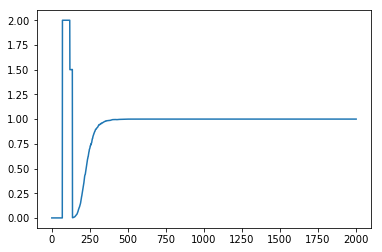

In [464]:
plt.plot([hard_func(np.array(m).reshape(2)) for m in mus])

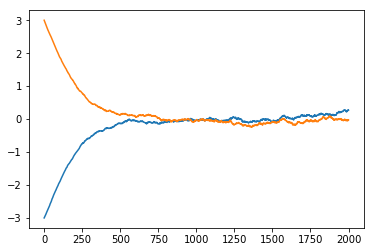

In [465]:
plt.plot([float(s[:,0]) for s in mus])
plt.plot([float(s[:,1]) for s in mus])

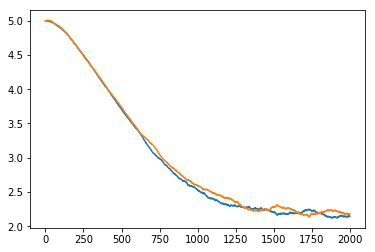

In [466]:
plt.plot([s[0,0] for s in sigmas])
plt.plot([s[1,1] for s in sigmas])